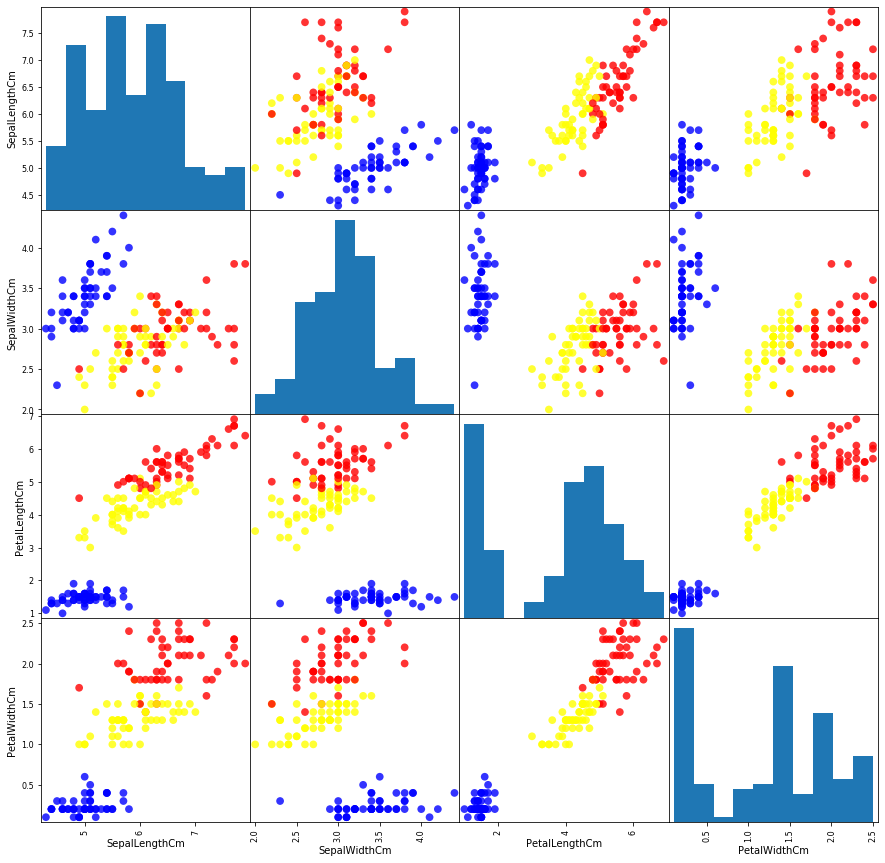

In [1]:
import os
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing 
import math
import warnings

'''
My Own Algorithms Import
'''
from preprocessing.scaler import MinMaxScaler, StandardScaler
from preprocessing.pca import PCA
from supervisedLearningAlgorithms.knn import KNN
from analysis.confusion_matrix import ConfusionMatrix
from analysis.roc import ROC


#Ignore Warnings
warnings.filterwarnings("ignore")

#read data
iris_data = pd.read_csv('data-sets/iris.csv')

#randomize data with given seed
iris_data = iris_data.reindex(np.random.RandomState(seed=42).permutation(iris_data.index))
    
def assign_colors_to_iris(y_train):
    colors = []
    for row in y_train:
        assigned = "blue"
        if (row == "Iris-versicolor"):
            assigned = "yellow"
        elif(row == "Iris-virginica"):
            assigned = "red"
        colors.append(assigned)
    return colors
pd.plotting.scatter_matrix(iris_data[["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"]], marker='o', s=60, alpha=0.8, figsize=(15, 15), color=assign_colors_to_iris(iris_data['Species']))
plt.show()

## Analyze the Data

In [2]:
iris_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 73 to 102
Data columns (total 6 columns):
Id               150 non-null int64
SepalLengthCm    150 non-null float64
SepalWidthCm     150 non-null float64
PetalLengthCm    150 non-null float64
PetalWidthCm     150 non-null float64
Species          150 non-null object
dtypes: float64(4), int64(1), object(1)
memory usage: 8.2+ KB


In [3]:
iris_data.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
73,74,6.1,2.8,4.7,1.2,Iris-versicolor
18,19,5.7,3.8,1.7,0.3,Iris-setosa
118,119,7.7,2.6,6.9,2.3,Iris-virginica
78,79,6.0,2.9,4.5,1.5,Iris-versicolor
76,77,6.8,2.8,4.8,1.4,Iris-versicolor


## Set up Data - remove all Iris-versicolor classifications

In [4]:
iris_data_2_classes = iris_data[iris_data['Species'] != 'Iris-versicolor']

In [5]:
seventy_five__percentile = int(len(iris_data_2_classes)*0.75) 
x_train, y_train = iris_data_2_classes.drop(['Species'], axis=1)[:seventy_five__percentile], iris_data_2_classes['Species'][:seventy_five__percentile]
x_test, y_test = iris_data_2_classes.drop(['Species'], axis=1)[seventy_five__percentile:], iris_data_2_classes['Species'][seventy_five__percentile:]
x_train.drop(["Id"], inplace=True, axis=1)
x_train.reset_index(drop=True, inplace=True)
x_test.drop(["Id"], inplace=True, axis=1)
x_test.reset_index(drop=True, inplace=True)

## Feature Scaling

In [6]:
x_train.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,5.7,3.8,1.7,0.3
1,7.7,2.6,6.9,2.3
2,5.4,3.4,1.5,0.4
3,6.9,3.1,5.1,2.3
4,6.5,3.2,5.1,2.0


Min Max Scaler

In [7]:
min_max_scaler = MinMaxScaler((0, 1))
x_train_min_max_scaled = min_max_scaler.fit_transform(x_train)
x_train_min_max_scaled.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
0,0.388889,0.727273,0.118644,0.083333
1,0.944444,0.181818,1.000000,0.916667
2,0.305556,0.545455,0.084746,0.125000
3,0.722222,0.409091,0.694915,0.916667
4,0.611111,0.454545,0.694915,0.791667


## Principal Component Analysis 2 Dimensions

No handles with labels found to put in legend.


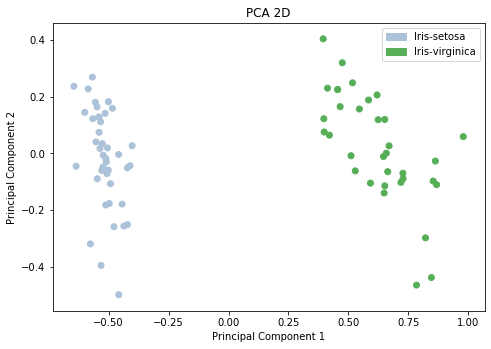

In [8]:
my_pca2 = PCA(2)
pca2_x_train_scaled = my_pca2.fit_transform(x_train_min_max_scaled)
my_pca2.plot("PCA 2D", y_train.values)

## Transform Test Dimensions

No handles with labels found to put in legend.


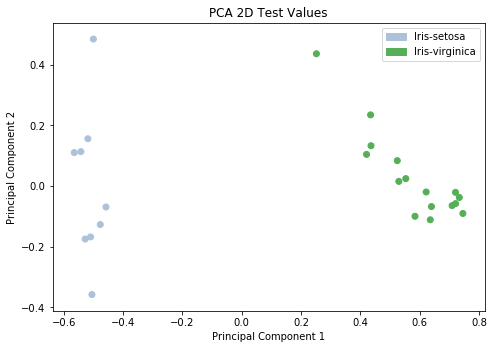

In [9]:
x_test_scaled = min_max_scaler.transform(x_test)
my_pca2.fit(x_train_min_max_scaled)
pca2_test_scaled = my_pca2.transform(x_test_scaled)
my_pca2.plot("PCA 2D Test Values", y_test.values)

# Support Vector Machine

In [10]:
from random import random

class SVM:
    def fit(self, X, y, learning_rate = 0.01, regularization_parameter = 1/1000, iterations=1000):
        unique_labels = np.unique(y)
        print(unique_labels)
        if (len(unique_labels) != 2):
            print("This method is meant for only 2 classifications at the moment")
            return
        self.labels_dict = {-1: unique_labels[0], 1: unique_labels[1]}
        y = [-1 if label==unique_labels[0] else 1 for label in y]
        self.X = X
        self.x_matrix = X.to_numpy()
        self.theta, self.b = self.gradient_descent(X, y, learning_rate, regularization_parameter, iterations)
        
    def gradient_descent(self, X, y, learning_rate, regularization_parameter, iterations):
        theta = np.array([0]*len(X.columns))
        b = 0
        X = X.to_numpy()
        size = len(X)
        for i in range(iterations):
            feature_index_random = int(random()*size)
            random_prediction = y[feature_index_random]
            feature_random = X[feature_index_random]
            hyperplane = np.dot(theta, feature_random)+b
            hyperplane_decision_factor = 1 - (random_prediction*hyperplane)
            #adjust b and theta
            if (hyperplane_decision_factor > 0):
                b = b + learning_rate*random_prediction
                theta = theta + 1/size*random_prediction*feature_random - 2*learning_rate*regularization_parameter*theta
            else:
                theta -= 2*learning_rate*regularization_parameter*theta
        return theta, b
    
    def predict(self, X):
        predictions = []
        X = X.to_numpy()
        for sample in X:
            prediction = np.dot(self.theta, sample)+self.b
            predictions.append(prediction)
        predictions_adjusted_to_int = [-1 if result < 0 else 1 for result in predictions]
        predictions_as_labels = [self.labels_dict[prediction] for prediction in predictions_adjusted_to_int]
        return predictions_as_labels

In [11]:
svm = SVM()
svm.fit(pca2_x_train_scaled, y_train.values)

['Iris-setosa' 'Iris-virginica']


In [12]:
predictions = svm.predict(pca2_test_scaled)

## Confusion Matrix

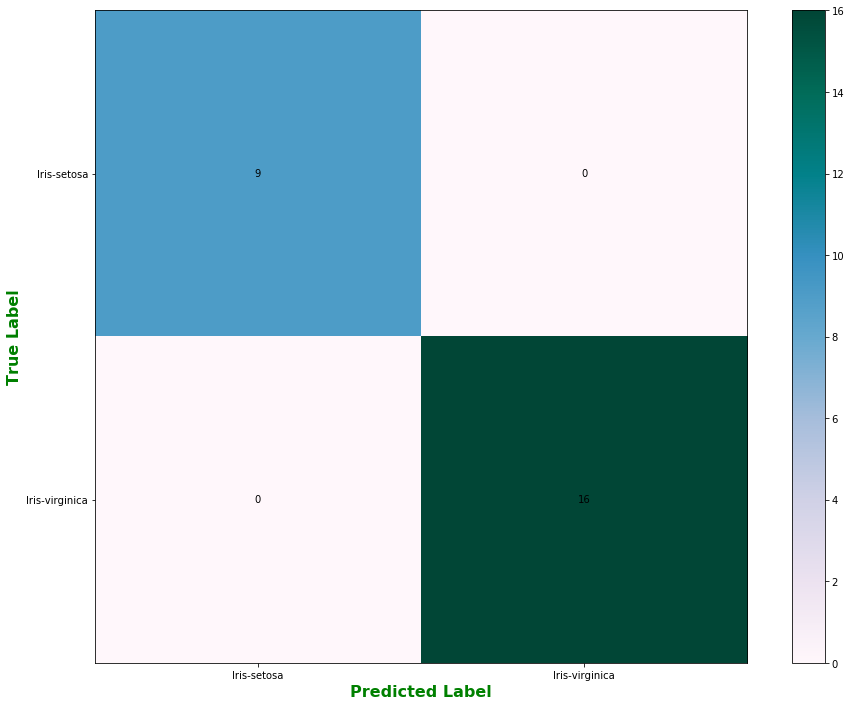

In [13]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(predictions, y_test.values)
confusion_matrix.plot()

## Compare with sklearn

In [14]:
from sklearn.svm import SVC
clf = SVC(gamma='auto')
clf.fit(pca2_x_train_scaled, y_train)
SVC(gamma='auto')
skpredictions2d = clf.predict(pca2_test_scaled)
skpredictions2d

array(['Iris-setosa', 'Iris-virginica', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica', 'Iris-setosa', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica', 'Iris-setosa', 'Iris-virginica',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-virginica', 'Iris-setosa', 'Iris-virginica', 'Iris-setosa',
       'Iris-virginica'], dtype=object)

## Confusion Matrix

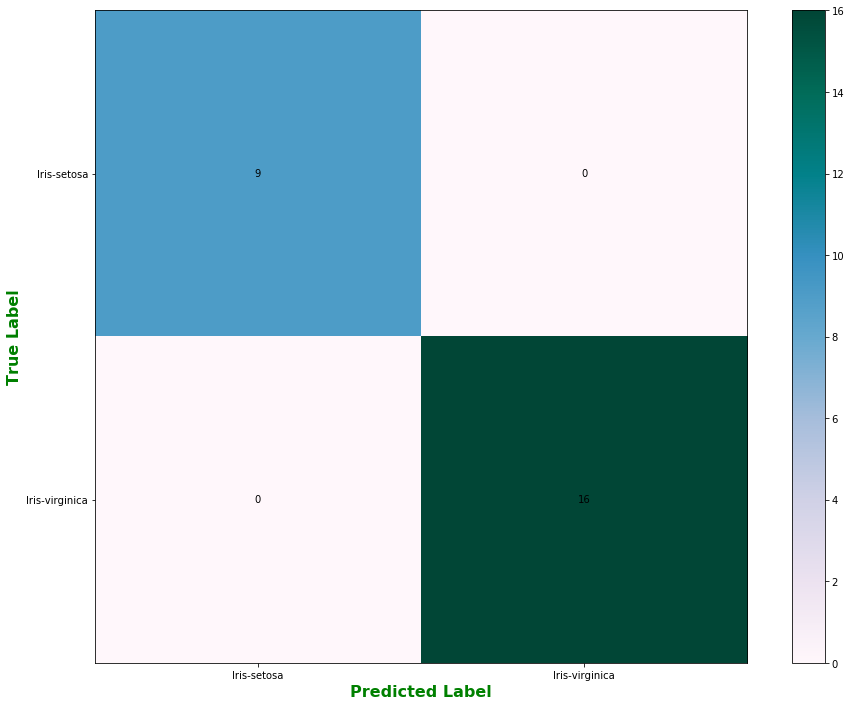

In [15]:
confusion_matrix = ConfusionMatrix()
confusion_matrix.fit(skpredictions2d, y_test.values)
confusion_matrix.plot()